# Test Masking 

In [1]:
%cd ..
%pwd

/home/sglarsen/Dev/AI-Event-Monitoring


'/home/sglarsen/Dev/AI-Event-Monitoring'

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5
Mean Absolute Error: 0.001384735107421875



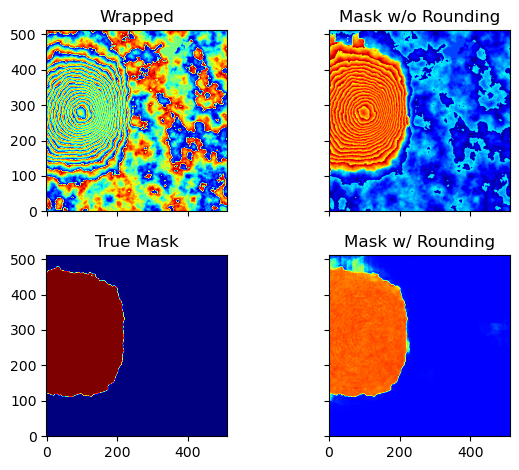


Running tests over 100 Simulated Interferograms
_______

CORRECT!   Guess: Positive   Actual: Positive   Count: 0
CORRECT!   Guess: Positive   Actual: Positive   Count: 1
CORRECT!   Guess: Positive   Actual: Positive   Count: 2
CORRECT!   Guess: Positive   Actual: Positive   Count: 3
CORRECT!   Guess: Positive   Actual: Positive   Count: 4
CORRECT!   Guess: Positive   Actual: Positive   Count: 5
CORRECT!   Guess: Positive   Actual: Positive   Count: 6
CORRECT!   Guess: Positive   Actual: Positive   Count: 7
CORRECT!   Guess: Positive   Actual: Positive   Count: 8
CORRECT!   Guess: Positive   Actual: Positive   Count: 9
CORRECT!   Guess: Positive   Actual: Positive   Count: 10
CORRECT!   Guess: Positive   Actual: Positive   Count: 11
CORRECT!   Guess: Positive   Actual: Positive   Count: 12
CORRECT!   Guess: Positive   Actual: Positive   Count: 13
CORRECT!   Guess: Positive   Actual: Positive   Count: 14
CORRECT!   Guess: Positive   Actual: Positive   Count: 15
CORRECT!   Guess: Positi

In [2]:
from os import environ

environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import load_model
from insar_eventnet.sarsim import gen_simulated_deformation, gen_sim_noise
import numpy as np
import matplotlib.pyplot as plt

def plot_imgs(wrapped, true_mask, pred_mask, pred_mask_rounded):
    """
    Helper for plotting the results of a mask prediction along with its corresponding
    truths.
    """

    rnd_indices = pred_mask < 0.4
    pred_mask_rounded = np.copy(wrapped)
    pred_mask_rounded[rnd_indices] = pred_mask_rounded[rnd_indices] - 10

    _, [[axs_wrapped, axs_mask], [axs_unwrapped, axs_mask_rounded]] = plt.subplots(
        2, 2, sharex=True, sharey=True, tight_layout=True
    )

    axs_wrapped.set_title("Wrapped")
    axs_wrapped.imshow(wrapped, origin="lower", cmap="jet")

    axs_unwrapped.set_title("True Mask")
    axs_unwrapped.imshow(true_mask, origin="lower", cmap="jet")

    axs_mask.set_title("Mask w/o Rounding")
    axs_mask.imshow(pred_mask_rounded, origin="lower", cmap="jet")

    axs_mask_rounded.set_title("Mask w/ Rounding")
    axs_mask_rounded.imshow(pred_mask, origin="lower", cmap="jet")

    plt.show()

def mask_simulated(
    mask_model,
    seed: int,
    tile_size: int,
    crop_size: int = 0,
    verbose: bool = False,
    noise_only: bool = False,
    gaussian_only: bool = False,
    zero_output: bool = False,
    event_type: str = "quake",
    tolerance: float = 0.7,
) -> None:
    """
    Predicts the event-mask on a synthetic wrapped interferogram and plots the results.

    Parameters
    -----------
    model_path : str
        The path to the model that does the masking.
    seed : int
        A seed for the random functions. For the same seed, with all other values the
        same as well, the interferogram generation will have the same results. If left
        at 0, the results will be different every time.
    tile_size : int
        The dimensional size of the simulated interferograms to generate, this must
        match the input shape of the model.
    crop_size : int, Optional
        If the models output shape is different than the input shape, this value needs
        to be equal to the output shape.
    use_sim : bool, Optional
        Use simulated interferograms rather than synthetic interferograms
    """

    if crop_size == 0:
        crop_size = tile_size

    if not noise_only:
        unwrapped, mask, wrapped, presence = gen_simulated_deformation(
            seed=seed, tile_size=tile_size, event_type=event_type, log=verbose
        )
    else:
        unwrapped, mask, wrapped, presence = gen_sim_noise(
            seed=seed, tile_size=tile_size, gaussian_only=gaussian_only
        )

    wrapped = wrapped.reshape((1, tile_size, tile_size, 1))
    mask_pred = np.float32(mask_model.predict(wrapped).reshape((crop_size, crop_size)))
    wrapped = wrapped.reshape((tile_size, tile_size))

    rnd_indices = mask_pred >= tolerance

    mask_pred_rounded = np.zeros(mask_pred.shape)
    mask_pred_rounded[rnd_indices] = 1

    if zero_output:
        zeros = wrapped == 0
        mask[zeros] = 0
        mask_pred[zeros] = 0
        mask_pred_rounded[zeros] = 0

    return wrapped, mask, mask_pred, mask_pred_rounded, presence

def test_binary_choice(
    mask_model,
    pres_model,
    seed: int,
    tile_size: int,
    crop_size: int = 0,
    count: int = 0,
    plot: bool = False,
    use_rounded_mask: bool = False,
    positive_thresh: float = 0.5,
) -> None:
    """
    Evaluats a mask+binary model on the presence of events in simulated interferograms.

    Parameters
    -----------
    model_path : str
        The path to the model that masks images.
    pres_model_path : str
        The path to the model that predicts the presence of an event in a mask.
    seed : int
        A seed for the random functions. For the same seed, with all other values the
        same as well, the interferogram generation will have the same results. If left
        at 0, the results will be different every time.
    tile_size : int
        The dimensional size of the simulated interferograms to generate, this must
        match the input shape of the model.
    crop_size : int, Optional
        If the models output shape is different than the input shape, this value needs
        to be equal to the output shape.
    count : int, Optional
        Predict on [count] simulated or synthetic interferograms and log the results.
        The default value of 1 simply plots the single prediction.
    plot : bool, Optional
        Plot the incorrect guesses during testing.
    use_rounded_mask : bool, Optional
        Run binary model on the rounded mask or the raw mask.
    positive_thresh : bool, Optional
        Threshold for the binary model to consider an image positive.
    """

    print(f"\nRunning tests over {count} Simulated Interferograms\n_______\n")

    if crop_size == 0:
        crop_size = tile_size

    if count < 1:
        count = 1

    if seed != 0:
        np.random.seed(seed)

    seeds = np.random.randint(100000, 999999, count)

    total_pos = 0
    total_neg = 0

    total_pos_correct = 0
    total_neg_correct = 0
    total_pos_incorrect = 0
    total_neg_incorrect = 0

    quake_count = np.ceil(0.4 * count)
    dyke_count = quake_count + np.ceil(0.1 * count)
    sill_count = dyke_count + np.ceil(0.1 * count)
    mix_noise_count = sill_count + np.floor(0.3 * count)

    for i in range(count):
        event_type = ""
        noise_only = False
        gaussian_only = False

        if i < quake_count:
            event_type = "quake"
        elif i < dyke_count:
            event_type = "dyke"
        elif i < sill_count:
            event_type = "sill"
        else:
            noise_only = True
            gaussian_only = i >= mix_noise_count
            event_type = "gaussian_noise" if gaussian_only else "mixed_noise"

        wrapped, mask, mask_pred, mask_pred_rounded, presence = mask_simulated(
            mask_model,
            seed=seed,
            tile_size=tile_size,
            crop_size=crop_size,
            noise_only=noise_only,
            gaussian_only=gaussian_only,
            zero_output=False,
            event_type="quake",
            tolerance=0.7,
        )

        if use_rounded_mask:
            presence_pred = pres_model.predict(
                mask_pred_rounded.reshape(1, tile_size, tile_size, 1)
            )
        else:
            presence_pred = pres_model.predict(
                mask_pred.reshape(1, tile_size, tile_size, 1)
            )

        is_pos = presence[0] == 1

        if is_pos:
            total_pos += 1
        else:
            total_neg += 1

        is_pos_pred = presence_pred[0] >= positive_thresh

        actual = "Positive" if is_pos else "Negative"
        guess = "Positive" if is_pos_pred else "Negative"
        result = "CORRECT!  " if guess == actual else "INCORRECT!"

        print(f"{result} Guess: {guess}   Actual: {actual}   Count: {i}")

        if count > 1:
            correctness = guess == actual

            total_pos += int(is_pos)
            total_neg += int(not is_pos)

            if not correctness:
                if is_pos:
                    total_pos_incorrect += 1
                else:
                    total_neg_incorrect += 1
                if plot:
                    plot_imgs(wrapped, mask, mask_pred, mask_pred_rounded)

                print(f"\nSeed:       {seeds[i]}")
                print(f"Event Type: {event_type}")
                print(f"Presence:   {presence_pred[0]}")
            else:
                if is_pos:
                    total_pos_correct += 1
                else:
                    total_neg_correct += 1

    if count > 1:
        acc = 100 * (total_pos_correct + total_neg_correct) / count

        print("")
        print(f"True  Positives:  {total_pos_correct}")
        print(f"False Positives:  {total_pos_incorrect}")
        print(f"True  Negatives:  {total_neg_correct}")
        print(f"False Negatives:  {total_neg_incorrect}")
        print("")
        print(f"Overall Accuracy: {acc: 0.2f}%")
        print("_______\n")

    else:
        if plot:
            plot_imgs(wrapped, mask, mask_pred, mask_pred_rounded)

mask_model_path = "data/output/models/mask_model"
pres_model_path = "data/output/models/pres_model"
seed = 0
tile_size = 512
crop_size = 0
num_trials = 100

mask_model = load_model(mask_model_path)
pres_model = load_model(pres_model_path)

wrapped, mask, mask_pred, mask_pred_rounded, presence = mask_simulated(
    mask_model,
    seed,
    tile_size,
    crop_size
)

mean_absolute_error = np.mean(np.abs(mask - mask_pred_rounded))

print(f"Mean Absolute Error: {mean_absolute_error}\n")

plot_imgs(wrapped, mask, mask_pred, mask_pred_rounded)

test_binary_choice(
    mask_model,
    pres_model,
    seed,
    tile_size,
    crop_size,
    count=num_trials
)